# Création des Modèles de base

In [1]:
from app.models.mushroom_ml import Mushroom_ml
import pandas as pd
import sqlite3
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifierCV

In [2]:
# Read sqlite query results into a pandas DataFrame
conn = sqlite3.connect("mushrooms.sqlite")
df = pd.read_sql_query("SELECT * from data", conn)

# Analyse de la précision des models selon une CROSS VALIDATION (encoder=OneHotEncoder())

In [3]:
mushroom = Mushroom_ml(df=df.drop(['_id'], axis=1), target='_class', conn=conn)

In [4]:
a = mushroom.test_models(show=True)

model : LogisticRegression() => 0.9992947813822285
model : SGDClassifier() => 0.9996473906911143
model : RidgeClassifierCV() => 0.9992947813822285
model : LinearSVC() => 1.0
model : KNeighborsClassifier() => 0.9992947813822285
model : DecisionTreeClassifier() => 0.9992947813822285
model : StackingClassifier(estimators=[('model_1',
                                KNeighborsClassifier(n_neighbors=10)),
                               ('model_2', RandomForestClassifier())],
                   final_estimator=DecisionTreeClassifier()) => 1.0
model : AdaBoostClassifier() => 1.0
model : GradientBoostingClassifier() => 0.9992947813822285
model : RandomForestClassifier(n_estimators=10) => 1.0


# FEATURE SELECTION (MODEL:DECISIONTREE, ENCODER:ONEHOTENCODER)

## Features_importances (distance euclidienne) des coefficients

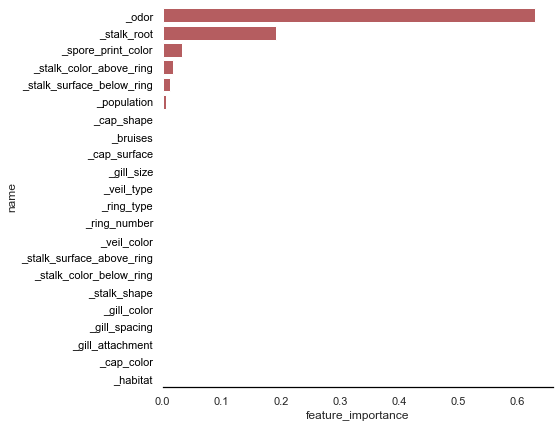

In [5]:
a = mushroom.features_importances()

## Evaluations des features offrants les meilleurs résultats en matière de Précision

In [6]:
mushroom.feature_selection(sendmodel=DecisionTreeClassifier()).head()

,feature,results
4,_odor,0.973518
6,_gill_spacing,0.913931
19,_spore_print_color,0.892613
17,_ring_number,0.883749
3,_bruises,0.821513


In [7]:
mushroom.feature_selection(['_odor'],sendmodel=DecisionTreeClassifier()).head()

,feature,results
18,_spore_print_color,0.989512
11,_stalk_surface_below_ring,0.981894
20,_habitat,0.981617
2,_cap_color,0.979252
13,_stalk_color_below_ring,0.978906


In [8]:
mushroom.feature_selection(['_odor', '_habitat'],sendmodel=DecisionTreeClassifier()).head()

,feature,results
18,_spore_print_color,0.995769
2,_cap_color,0.993682
9,_stalk_root,0.991946
3,_bruises,0.991247
10,_stalk_surface_above_ring,0.990205


In [9]:
mushroom.feature_selection(['_odor', '_habitat', '_cap_color'],sendmodel=DecisionTreeClassifier()).head()

,feature,results
8,_stalk_root,1.000000
2,_bruises,0.998239
17,_spore_print_color,0.998239
18,_population,0.997182
4,_gill_spacing,0.997182


# CONSTRUCTIONS DE MODELS

## Evaluation de la sélection avec les modèles

In [10]:
mushroom=Mushroom_ml(df[['_class','_odor', '_habitat', '_cap_color', '_bruises']],'_class', conn)

In [11]:
a = mushroom.test_models(show=True)

model : LogisticRegression() => 0.9785492964791251
model : SGDClassifier() => 0.9936728420143798
model : RidgeClassifierCV() => 0.973517888699717
model : LinearSVC() => 0.9926361461089682
model : KNeighborsClassifier() => 1.0
model : DecisionTreeClassifier() => 0.9982394366197183
model : StackingClassifier(estimators=[('model_1',
                                KNeighborsClassifier(n_neighbors=10)),
                               ('model_2', RandomForestClassifier())],
                   final_estimator=DecisionTreeClassifier()) => 0.9971821039229729
model : AdaBoostClassifier() => 0.9919472078549135
model : GradientBoostingClassifier() => 0.9936822250933147
model : RandomForestClassifier(n_estimators=10) => 0.9989426673032545


## KNeighborsClassifier

In [12]:
a = mushroom.test_models([KNeighborsClassifier()], show=True)

model : KNeighborsClassifier() => 1.0


### SCORE Model avec KNeighborsClassifier

accuracy : 0.999627004848937
precision : 1.0


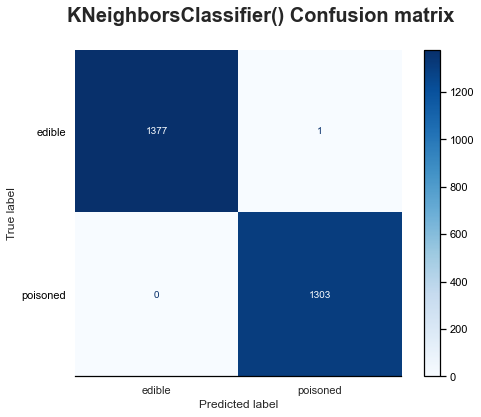

In [13]:
mushroom.score_model(KNeighborsClassifier())

### GRIDSEARCH pour saisir les meilleurs hyper parametres (métrique précision)

In [14]:
mushroom.grid_model(KNeighborsClassifier(), {
    "n_neighbors" : range(1,10),
    "metric": ["euclidean", "manhattan", "minkowski"]
})

Tuned Decision Tree Parameters: {'metric': 'euclidean', 'n_neighbors': 1}
Best score is 1.0


{'metric': 'euclidean', 'n_neighbors': 1}

### SCORE Model avec KNeighborsClassifier(meilleurs parametres)

accuracy : 0.999627004848937
precision : 1.0


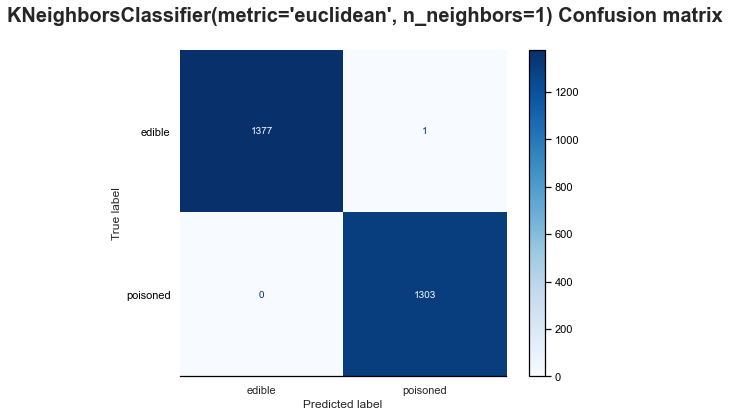

In [15]:
mushroom.score_model(KNeighborsClassifier(n_neighbors=1, metric='euclidean'))

### Analyse Learning Curve

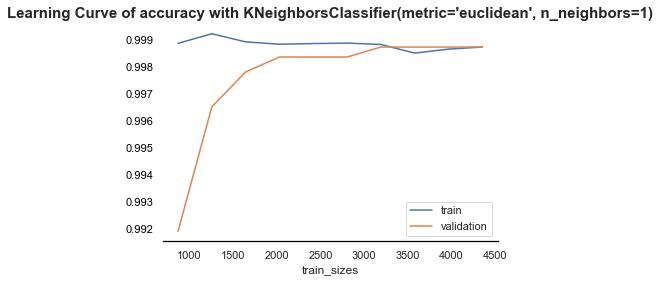

In [16]:
mushroom.learning_graph(sendmodel=KNeighborsClassifier(n_neighbors=1, metric='euclidean'))

## RidgeClassifierCV

In [17]:
a = mushroom.test_models([RidgeClassifierCV()], show=True)

model : RidgeClassifierCV() => 0.973517888699717


### SCORE Model avec RidgeClassifierCV

accuracy : 0.9839612085042895
precision : 0.9697396199859254


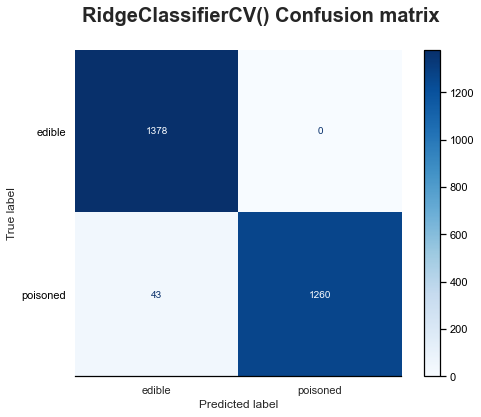

In [18]:
mushroom.score_model(RidgeClassifierCV())

### GRIDSEARCH pour saisir les meilleurs hyper parametres (métrique précision)

In [19]:
mushroom.grid_model(RidgeClassifierCV(), {
    'alphas' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
})

Tuned Decision Tree Parameters: {'alphas': 0.1}
Best score is 0.9735406571849318


{'alphas': 0.1}

### SCORE Model avec RidgeClassifierCV(meilleurs parametres)

accuracy : 0.9839612085042895
precision : 0.9697396199859254


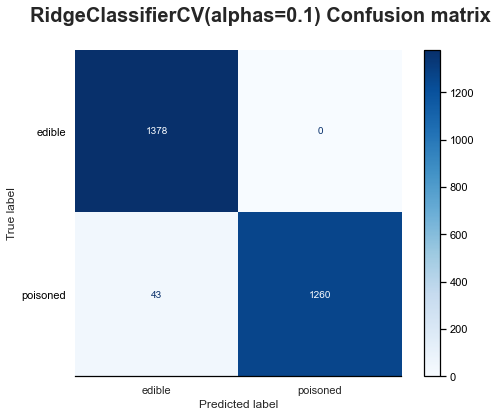

In [20]:
mushroom.score_model(RidgeClassifierCV(alphas=0.1))

### Analyse Learning Curve

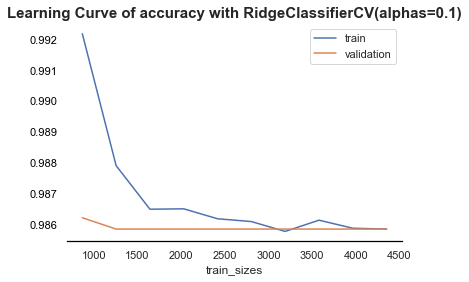

In [21]:
mushroom.learning_graph(sendmodel=RidgeClassifierCV(alphas=0.1))

## LogisticRegression

In [22]:
a = mushroom.test_models([LogisticRegression()], show=True)

model : LogisticRegression() => 0.9785492964791251


### SCORE Model avec LogisticRegression

accuracy : 0.9858261842596047
precision : 0.9758522727272727


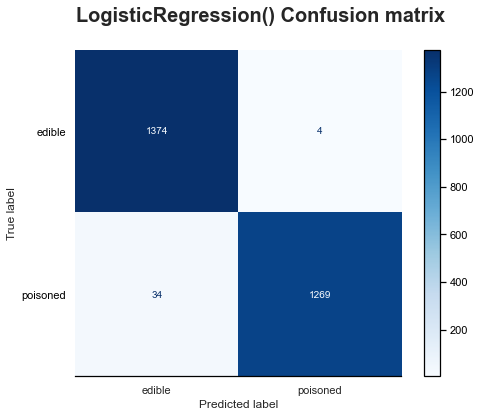

In [23]:
mushroom.score_model(LogisticRegression())

### GRIDSEARCH pour saisir les meilleurs hyper parametres (métrique précision)

In [24]:
mushroom.grid_model(LogisticRegression(), {
    'C' : [10, 1.0, 0.1, 0.01],
})

Tuned Decision Tree Parameters: {'C': 10}
Best score is 0.9919389319560793


{'C': 10}

### SCORE Model avec LogisticRegression(meilleurs parametres)


accuracy : 0.9962700484893696
precision : 0.9927953890489913


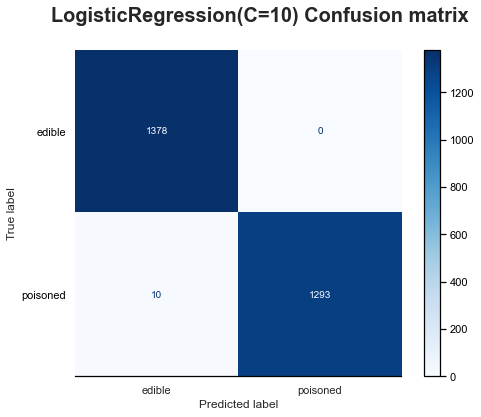

In [25]:
mushroom.score_model(LogisticRegression(C=10))

### Analyse Learning Curve

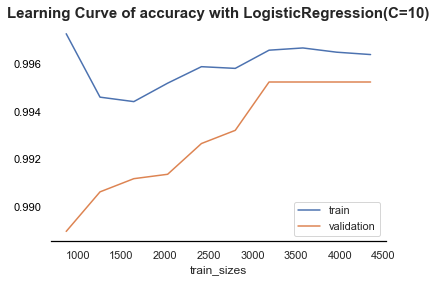

In [26]:
mushroom.learning_graph(sendmodel=LogisticRegression(C=10))

## DECISIONTREECLASSIFIER

### SCORE Model avec DecisionTreeClassifier()

accuracy : 0.999627004848937
precision : 1.0


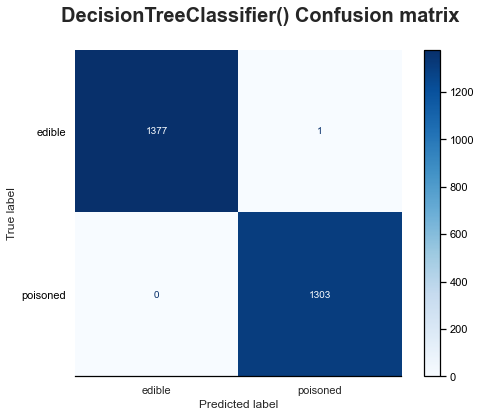

In [27]:
mushroom.score_model()

### GRIDSEARCH pour saisir les meilleurs hyper parametres (métrique précision)

In [28]:
mushroom.grid_model(DecisionTreeClassifier(), {
    "criterion" : ['gini', 'entropy','log_loss'],
    "max_depth" : range(4,15)
})

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9}
Best score is 0.9982412931013144


{'criterion': 'gini', 'max_depth': 9}

### SCORE Model avec DecisionTreeClassifier(meilleurs parametres)

accuracy : 0.999627004848937
precision : 1.0


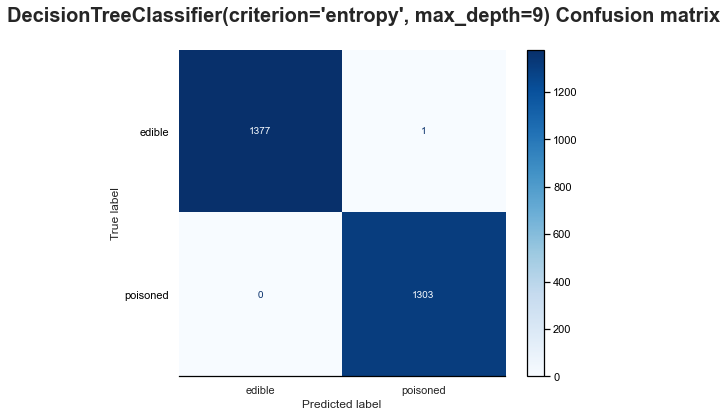

In [29]:
mushroom.score_model(DecisionTreeClassifier(criterion='entropy',max_depth=9,min_samples_leaf=1,min_samples_split=2))

### Analyse Learning Curve

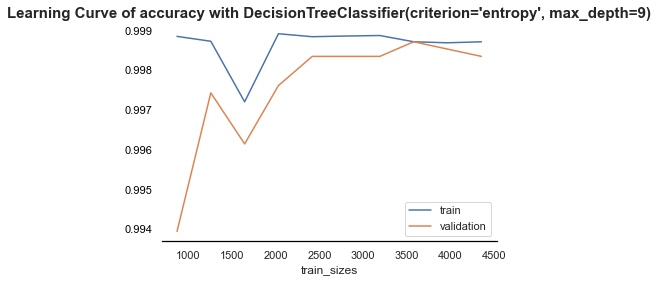

In [30]:
mushroom.learning_graph(sendmodel=DecisionTreeClassifier(criterion='entropy',max_depth=9,min_samples_leaf=1,min_samples_split=2))

## OUTWORK BEST PRATICAL FEATURES

In [31]:
mushroom=Mushroom_ml(
    df[['_class',
        '_odor',
        '_habitat',
        '_cap_color',
        '_population',
        '_bruises'
    ]],'_class', conn)

accuracy : 1.0
precision : 1.0


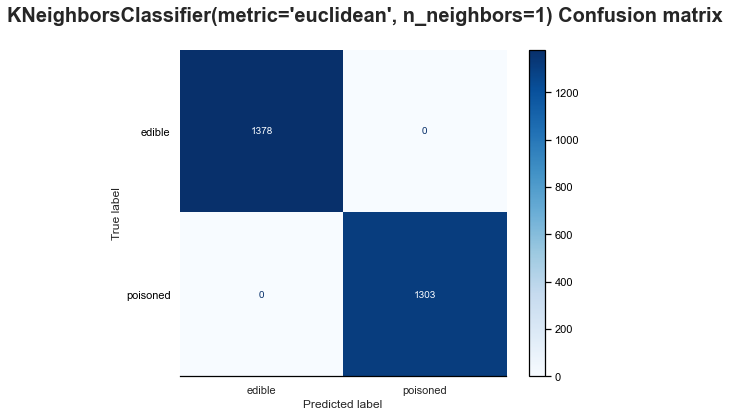

In [32]:
mushroom.score_model(KNeighborsClassifier(n_neighbors=1, metric='euclidean'), display=False)

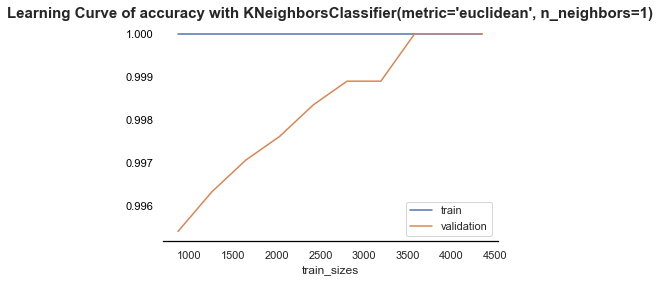

In [33]:
mushroom.learning_graph(KNeighborsClassifier(n_neighbors=1, metric='euclidean'))

### SCORE MODEL

accuracy : 1.0
precision : 1.0


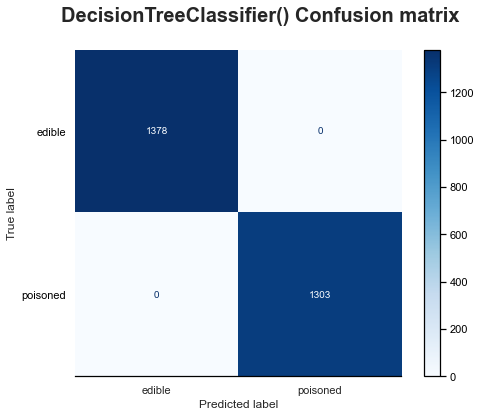

In [34]:
mushroom.score_model(DecisionTreeClassifier(), display=False)

### Gridsearch

In [35]:
mushroom.grid_model(DecisionTreeClassifier(), {
    "criterion" : ['gini', 'entropy','log_loss'],
    "max_depth" : range(4,15)
})

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 10}
Best score is 1.0


{'criterion': 'gini', 'max_depth': 10}

### SCORE WITH BEST_PARAMS

accuracy : 1.0
precision : 1.0


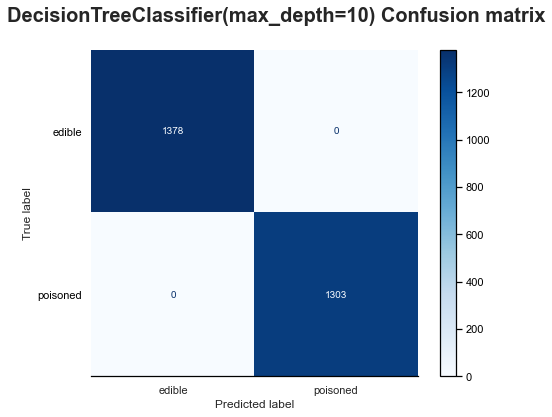

In [36]:
mushroom.score_model(DecisionTreeClassifier(max_depth=10), display=False)

### Analyse Learning Curve

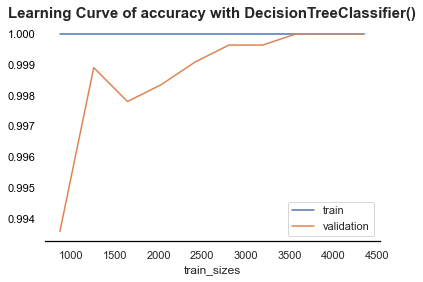

In [37]:
mushroom.learning_graph()

### Plot Tree

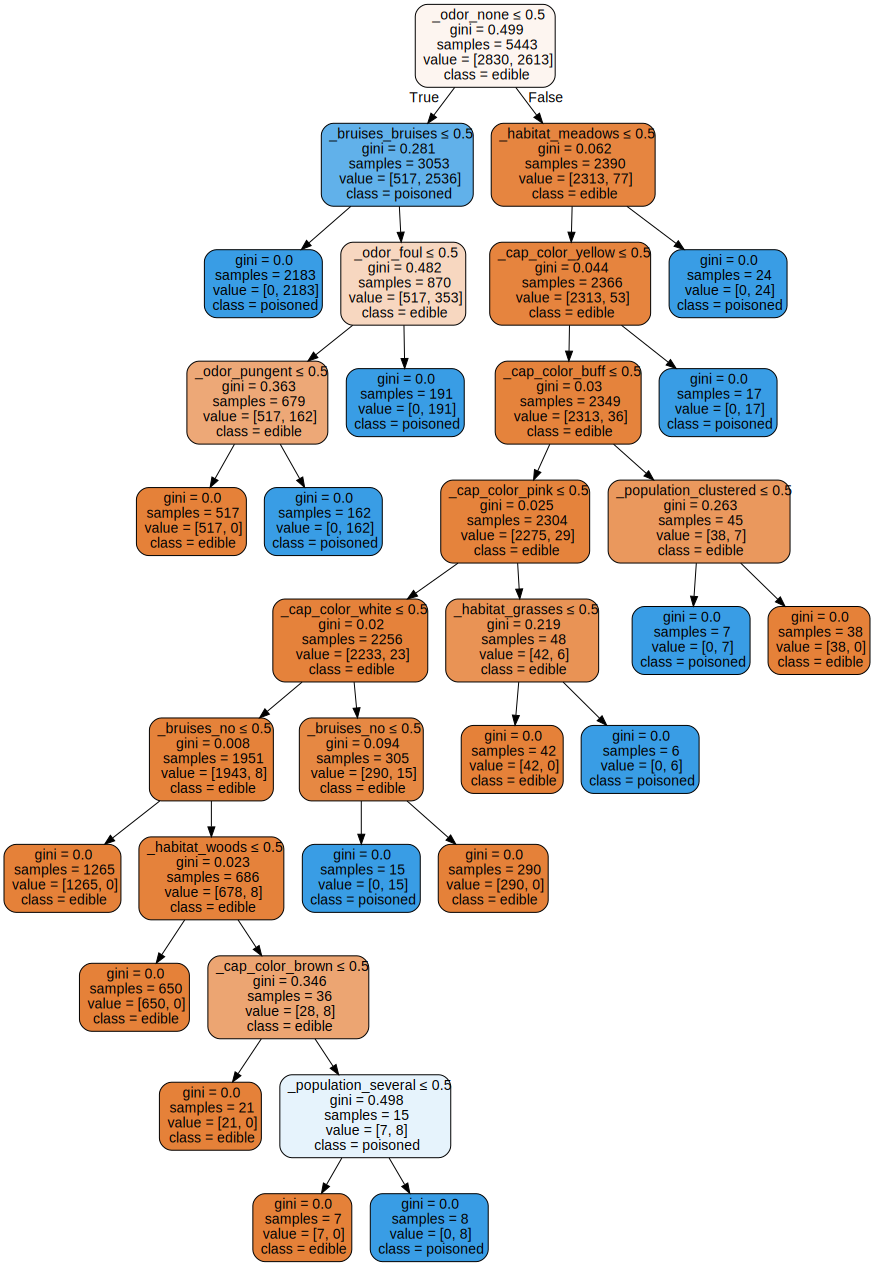

In [38]:
mushroom.tree_vis()